In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv( "/content/drive/MyDrive/HorizonHW/Project/spam.csv", usecols=['v1','v2'], encoding='latin-1' )

In [4]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
map = { 'spam': 1, 'ham': 0 }
df[ 'spam' ] = df[ 'v1' ].map( map )

In [6]:
df.head()

,v1,v2,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
print( len( df[ df.spam == 1 ] ) )
print( len( df[ df.spam == 0 ] ) )

747
4825


In [8]:
features = df[ 'v2' ].values.tolist()
labels = df[ 'spam' ].values.tolist()

In [19]:
#Sets the size of the train and test sets and splits the data up
training_size = int( len( features ) * 0.7 )
test_size = int( len( features ) * 0.9 )

training_features = features[ 0 : training_size ]
training_labels = labels[ 0 : training_size ]
test_features = features[ training_size : test_size ]
test_labels = labels[ training_size : test_size ]

check_features = features[ test_size : ]
check_labels = labels[ test_size : ]

#Converts labels into np arrays for use in the network
training_labels_f = np.array( training_labels )
test_labels_f = np.array( test_labels )

In [20]:
#Initializes information necessary for tokenization
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [21]:
#Creates a word index based on the training features and orders the words in each feature appropriately
tokenizer = Tokenizer( num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts( training_features )
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences( training_features )

In [22]:
#Padding is added to ensure each string is of the same length
pad = pad_sequences( sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type )

#Transforms texts to sequence of integers
test_sequences = tokenizer.texts_to_sequences( test_features )
test_padded = pad_sequences( test_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type )

In [55]:
#Architecture of the Neural Network
model = tf.keras.Sequential( [tf.keras.layers.Embedding( vocab_size, embedding_dim, input_length = max_length ), 
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense( 6, activation = 'relu' ),
                              tf.keras.layers.Dense( 1, activation = 'sigmoid' )
                              ] )

model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 16)           16000     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 9606      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 7         
Total params: 25,613
Trainable params: 25,613
Non-trainable params: 0
_________________________________________________________________


In [56]:
epoch = 20
history = model.fit( pad, training_labels_f, epochs = epoch, validation_data = ( test_padded, test_labels_f ) )

Epoch 1/20
122/122 [==============================] - 1s 4ms/step - loss: 0.3186 - accuracy: 0.8662 - val_loss: 0.2066 - val_accuracy: 0.8600
Epoch 2/20
122/122 [==============================] - 0s 3ms/step - loss: 0.1633 - accuracy: 0.9292 - val_loss: 0.1427 - val_accuracy: 0.9695
Epoch 3/20
122/122 [==============================] - 0s 3ms/step - loss: 0.0765 - accuracy: 0.9803 - val_loss: 0.0737 - val_accuracy: 0.9785
Epoch 4/20
122/122 [==============================] - 0s 3ms/step - loss: 0.0439 - accuracy: 0.9885 - val_loss: 0.0649 - val_accuracy: 0.9803
Epoch 5/20
122/122 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9908 - val_loss: 0.0559 - val_accuracy: 0.9829
Epoch 6/20
122/122 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.0564 - val_accuracy: 0.9829
Epoch 7/20
122/122 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.9949 - val_loss: 0.0606 - val_accuracy: 0.9838
Epoch 

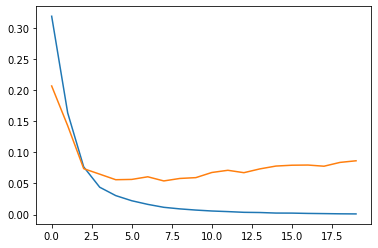

In [57]:
plt.plot( history.history[ 'loss' ] )
plt.plot( history.history[ 'val_loss' ] )

In [58]:
#Converts the check set into tokenized and padded sequences
padding_type = 'post'
sample_sequences = tokenizer.texts_to_sequences( check_features )
checks_padded = pad_sequences( sample_sequences, padding = padding_type, maxlen = max_length )

classes = model.predict( checks_padded )
classes_rounded = classes

#Initializes variables to check accuracy of the model
unsure = 0
correct = 0
wrong = 0

#Runs through the check array and finds the number of unsure, correct, and incorrect predictions
for x in range( len( check_features ) ):
  if classes[x] < 0.4:
    classes_rounded[x] = 0
  elif classes[x] > 0.6:
    classes_rounded[x] = 1
  else:
    classes_rounded[x] = 2
  
  if classes_rounded[x] == 2:
    unsure += 1
  elif classes_rounded[x] == check_labels[x]:
    correct += 1
  else:
    wrong += 1

print( "The model made " + str( correct ) + " correct predictions, " + str( wrong ) + " wrong predictions, " + " and was unsure " + str( unsure ) + " times." )

The model made 549 correct predictions, 7 wrong predictions,  and was unsure 2 times.
